<a href="https://colab.research.google.com/github/bipin-a/Machine-Learning-Notes/blob/main/Window_Creation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import math
import numpy as np
from scipy.stats import entropy
from scipy.signal import find_peaks
from sklearn.preprocessing import PowerTransformer
from datetime import timedelta
from math import log2
from scipy.signal import peak_prominences
import tensorflow as tf
import json
import random
import gc
from sklearn.model_selection import train_test_split
from typing import Union
from collections import namedtuple

import numpy.typing as npt

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))


Num GPUs Available:  1


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data_dir = "/content/drive/Shareddrives/BipinA/Neural_Networks_Data/"

In [ ]:
daily_features = pd.concat([pd.read_csv(f"{data_dir}daily_features.csv"),pd.read_csv(f"{data_dir}daily_features_pt2.csv")])
weekly_features = pd.read_csv(f"{data_dir}weekly_features.csv")
monthly_features = pd.concat([pd.read_csv(f"{data_dir}monthly_features_1.csv"),
                              pd.read_csv(f"{data_dir}monthly_features_2.csv"),
                              pd.read_csv(f"{data_dir}monthly_features_3.csv"),
                              pd.read_csv(f"{data_dir}monthly_features_4.csv"),
                              pd.read_csv(f"{data_dir}monthly_features_5.csv"),
                              ])

all_features = pd.concat([daily_features,weekly_features,monthly_features])
del daily_features, weekly_features, monthly_features

In [ ]:
time_series = all_features.fit_forecast.map(lambda x : json.loads(x).get("raw") )
time_series = pd.concat([time_series, all_features.V1, all_features.forecast_error], axis=1)



In [ ]:
time_series['FREQ'] = time_series['V1'].apply(lambda x :x[0])

In [ ]:
time_series[time_series.fit_forecast.apply(len) > time_series.fit_forecast.apply(len).quantile(0.45)].groupby("FREQ").count()


,fit_forecast,V1,forecast_error
FREQ,,,
D,3352,3352,3352
M,4004,4004,4004
W,286,286,286


In [ ]:
large_time_series = time_series[time_series.fit_forecast.apply(len) > time_series.fit_forecast.apply(len).quantile(0.45)]


In [ ]:
sample_time_series = pd.concat( [
                    large_time_series[(large_time_series.FREQ=="D") & (large_time_series.forecast_error < 0.1)].sample(1100),
                    large_time_series[(large_time_series.FREQ=="M") & (large_time_series.forecast_error < 0.1)].sample(1100),
                    large_time_series[(large_time_series.FREQ=="W") & (large_time_series.forecast_error < 0.1)] 
                    ] )
                                


(array([1100.,    0.,    0.,    0.,    0., 1100.,    0.,    0.,    0.,
         217.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

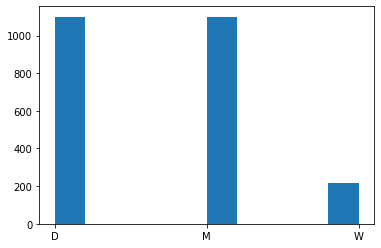

In [ ]:
plt.hist(sample_time_series.FREQ)

1. Train it on all data 

2. Train each model on one feature of data (i.e highly periodic) 


In scope:
Find which model does the best on what features.

Out of scope:
Train that model on those time series specifically --> 

ANN is better for series with low trend and high periodicity 

# Experiment A: 

Preprocessing: 
- Normalize: Standardize  

Training 
1. MAE error function
2. cumlative error function 

Testing 
1. 30 Days
2. 90 Days
3. 180 Days

Models:
- ANN
- LSTM
- CNN
- RNN

# Experiment B: 
Preprocessing:
- Normalize: Z score

Training 
1. MAE error function
2. cumlative error function 

Testing 
1. 30 Days
2. 90 Days
3. 180 Days

Models:
- ANN
- LSTM
- CNN
- RNN


# Experiment C: 
Preprocessing:
None

Training 
1. MAE error function
2. cumlative error function

Testing 
1. 30 Days
2. 90 Days
3. 180 Days

Models:
- ANN
- LSTM
- CNN
- RNN

Losses

The purpose of loss functions is to compute the quantity that a model should seek to minimize during training.

Metrics

A metric is a function that is used to judge the performance of your model.
Metric functions are similar to loss functions, except that the results from evaluating a metric are not used when training the model. Note that you may use any loss function as a metric.



# Experiment 1

In [ ]:
def get_X_Y_windows(series:pd.Series,
                    INPUT_SIZE:int,
                    OUTPUT_SIZE:int, 
                    STEP_SIZE:int,
                    _scaler) -> Union[npt.NDArray,npt.NDArray]:
  
  test_end = series.shape[0] 
  test_start = test_end - OUTPUT_SIZE
  train_end = test_start - 1
  train_start =  train_end - INPUT_SIZE

  all_features = []
  all_labels = []

  while train_start > 0:
    features = np.array(series.iloc[train_start:train_end].values)
    label = np.array(series.iloc[test_start:test_end].values)

    min,max, mean, std = get_stats(features)
    features = custom_scaler(scaler=_scaler, X=features,
                                min=min, max=max,
                                mean=mean, std=std)
    label = custom_scaler(scaler=_scaler, X=label,
                                min=min, max=max,
                                mean=mean, std=std)

    all_features.append(features)
    all_labels.append(label)
    test_end -= STEP_SIZE
    test_start = test_end - OUTPUT_SIZE
    train_end = test_start - 1
    train_start =  train_end - INPUT_SIZE
  
  return np.array(all_features), np.array(all_labels)

In [ ]:
Experiment = namedtuple("Experiment", "X_train Y_train X_test Y_test X_val Y_val OUTPUT_SIZE scaler_name TS_Train TS_Test TS_Val")

In [ ]:
class MinMax:
  def scale(self,X:pd.Series, min:int, max: int):
    return  (X - min) / (max - min) 

class Standardize:
  def scale(self, X:pd.Series, mean:int, std: int) -> pd.Series:
    return (X-mean) / std

class Nada:
  def scale(self, X:pd.Series, mean:int, std: int) -> pd.Series:
    return None

def custom_scaler(scaler, X:pd.Series, min:int, max:int,mean:int, std: int) -> pd.Series:
  if type(scaler).__name__ == "MinMax": 
    return scaler.scale(X, min, max)
  elif type(scaler).__name__ == "Standardize":
    return scaler.scale(X, mean, std)
  elif type(scaler).__name__ == "Nada":
    return X

def get_stats(X:npt.NDArray)-> list:
  min = np.min(X)
  max = np.max(X)
  mean = np.mean(X)
  std = np.std(X)
  return [min, max, mean, std]

In [ ]:
gc.enable()
gc.collect()


322

In [ ]:
gc.enable()
gc.collect()
INPUT_SIZE = 300
output_sizes = [30,120,270]
STEP_SIZE = 3
minmaxscaler = MinMax()
standardizescaler = Standardize()
nada = Nada()
n_features = 1

for OUTPUT_SIZE in output_sizes:
    for scaler in [minmaxscaler, standardizescaler, nada]:
        # Experiment begins
        X_val = np.empty((INPUT_SIZE), int)
        Y_val = np.empty((OUTPUT_SIZE), int)
        X_train = np.empty((INPUT_SIZE), int)
        Y_train = np.empty((OUTPUT_SIZE), int)
        X_test = np.empty((INPUT_SIZE), int)
        Y_test = np.empty((OUTPUT_SIZE), int)
        TS_Train = []
        TS_Test = []
        TS_Val = []
        scaler_name = type(scaler).__name__
        EXP_NAME = str(OUTPUT_SIZE) + str(scaler_name)
        print(EXP_NAME)
        # TODO: Shuffle the time seriesdf
        c=0
        for row in sample_time_series.itertuples():
            ts_id = row.V1
            sample = pd.Series(row.fit_forecast)
            TOT = OUTPUT_SIZE + INPUT_SIZE + 100
            if (len(sample)>(TOT*2)):
                c += 1
                TEST_raw = sample.iloc[-TOT:]
                TRAIN_raw = sample.iloc[:-TOT]
                
                
                features_insample, labels_insample = get_X_Y_windows(TRAIN_raw,INPUT_SIZE,
                                                                        OUTPUT_SIZE, STEP_SIZE, scaler)
                _x_train,_x_val,_y_train,_y_val = train_test_split(features_insample, 
                                                                    labels_insample,
                                                                    shuffle=True,
                                                                    random_state=1)
                    
                features_test, labels_test = get_X_Y_windows(TEST_raw,INPUT_SIZE,OUTPUT_SIZE, STEP_SIZE, scaler)

                ts_id_test = [ts_id for i in range(features_test.shape[0])]
                ts_id_train = [ts_id for i in range(_x_train.shape[0])]
                ts_id_val = [ts_id for i in range(_x_val.shape[0])]
                # print("len id: ", len(ts_id_test))
                # print("features_test shape: ", features_test.shape)

                X_test = np.vstack((X_test,features_test))
                Y_test = np.vstack((Y_test,labels_test))
                X_train = np.vstack((X_train,_x_train))
                Y_train = np.vstack((Y_train, _y_train))
                X_val = np.vstack((X_val,_x_val))
                Y_val = np.vstack((Y_val,_y_val))
                TS_Train.extend(ts_id_train)
                TS_Test.extend(ts_id_test)
                TS_Val.extend(ts_id_val)
            else:
                continue
        print("Number of time series samples: ", c)
        X_test = X_test[1:]
        Y_test = Y_test[1:]
        X_train = X_train[1:]
        Y_train = Y_train[1:]
        X_val = X_val[1:]
        Y_val = Y_val[1:]

        # Samples for X and Y should be same within the split
        num_samples = X_train.shape[0]
        X_train = X_train.reshape((num_samples, INPUT_SIZE, n_features))
        Y_train = Y_train.reshape((num_samples, OUTPUT_SIZE, n_features))
        
        num_samples = X_test.shape[0]
        X_test = X_test.reshape((num_samples, INPUT_SIZE, n_features))
        # Y_test = Y_test.reshape((num_samples, E.OUTPUT_SIZE, n_features))  Not reshaping y_test, in order to plot easier later on

        num_samples = X_val.shape[0]
        X_val = X_val.reshape((num_samples, INPUT_SIZE, n_features))
        Y_val = Y_val.reshape((num_samples, OUTPUT_SIZE, n_features))
              
        # At the end of one experiment, add list of all data
        E = Experiment(X_train, Y_train, X_test, Y_test,
                                          X_val, Y_val, OUTPUT_SIZE, scaler_name, 
                                          TS_Train, TS_Test, TS_Val)
        import pickle
        with open(f"{data_dir}_ExperimentDictionary_{EXP_NAME}.pickle", 'wb') as f:
            pickle.dump(E, f, protocol=pickle.HIGHEST_PROTOCOL)

        gc.collect()

30MinMax
Number of time series samples:  1050
30Standardize
Number of time series samples:  1050
30Nada
Number of time series samples:  1050
120MinMax
Number of time series samples:  986
120Standardize
Number of time series samples:  986
120Nada
Number of time series samples:  986
270MinMax
Number of time series samples:  889
270Standardize
Number of time series samples:  889
270Nada
Number of time series samples:  889
